In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

dataset = pd.read_csv("ratings.csv", header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])


In [2]:
dataset

,user_id,movie_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [3]:

# Need to map movie ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of movies', num_movies)
print('Number of users', num_users)


Number of movies 9724
Number of users 610


In [4]:
#dataset

In [5]:
train.head()

,user_id,movie_id,rating,timestamp
1188,10,905,3.0,1455357531
66488,428,1141,4.0,1111525076
55175,365,6586,0.5,1488945273
72437,468,585,2.0,831400500
55903,369,91,4.0,1236830423


In [6]:
test.head()

,user_id,movie_id,rating,timestamp
93821,599,4930,2.0,1498510211
88824,573,1125,4.5,1186589732
15673,103,1508,4.0,1431969969
62333,414,2422,3.0,961518581
80471,509,734,3.0,1436024257


In [7]:
!pip install pydot

# MATRIX FACTORIZATION

In [8]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, dot

# Let's use a higher latent dimension.
latent_dim = 10

# Define model inputs
movie_input = Input(shape=[1], name='movie-input')
user_input = Input(shape=[1], name='user-input')

# Define embeddings for movies and users
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)

# Flatten the embeddings
movie_vec = Flatten(name='movie-flatten')(movie_embedding)
user_vec = Flatten(name='user-flatten')(user_embedding)

# Compute dot product of movie and user embeddings
prod = dot([movie_vec, user_vec], axes=-1, normalize=False, name='dot-product')

# Define the model
model = Model([user_input, movie_input], prod)

# Display the model summary
model.summary()


d:\Machine-Learning-Lab\.conda\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie-input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user-input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie-embedding (Embedding  (None, 1, 10)                97250     ['movie-input[0][0]']         
 )                                                                                                
                                                                                                  
 user-embedding (Embedding)  (None, 1, 10)                6110      ['user-input[0][0]']      

Epoch 1/10
2521/2521 [==============================] - 9s 3ms/step - loss: 10.9966
Epoch 2/10
2521/2521 [==============================] - 8s 3ms/step - loss: 3.5976
Epoch 3/10
2521/2521 [==============================] - 7s 3ms/step - loss: 1.8964
Epoch 4/10
2521/2521 [==============================] - 8s 3ms/step - loss: 1.3350
Epoch 5/10
2521/2521 [==============================] - 7s 3ms/step - loss: 1.0754
Epoch 6/10
2521/2521 [==============================] - 7s 3ms/step - loss: 0.9343
Epoch 7/10
2521/2521 [==============================] - 9s 4ms/step - loss: 0.8484
Epoch 8/10
2521/2521 [==============================] - 10s 4ms/step - loss: 0.7912
Epoch 9/10
2521/2521 [==============================] - 11s 4ms/step - loss: 0.7492
Epoch 10/10
2521/2521 [==============================] - 9s 4ms/step - loss: 0.7164


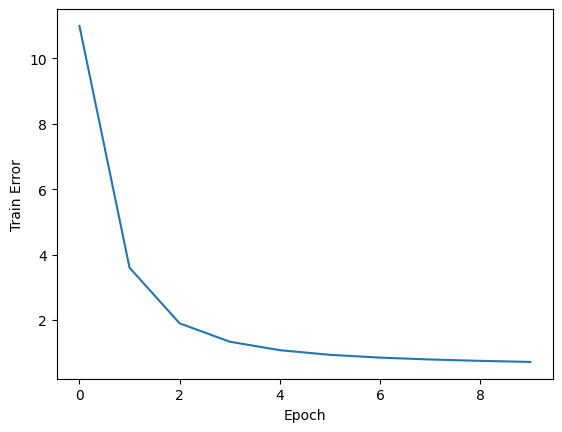

631/631 [==============================] - 1s 2ms/step
Mean Absolute Error: 0.7795180476572438


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)

# Plot training loss
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

# Evaluate the model
y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mae = mean_absolute_error(y_true, y_hat)
print("Mean Absolute Error:", mae)


In [10]:
y_hat

array([[2.51],
       [4.5 ],
       [3.39],
       ...,
       [3.49],
       [1.83],
       [3.35]], dtype=float32)

In [11]:
y_true

93821    2.0
88824    4.5
15673    4.0
62333    3.0
80471    3.0
        ... 
8433     4.0
40701    5.0
45537    4.0
66989    3.0
37544    4.5
Name: rating, Length: 20168, dtype: float64

In [12]:
from keras.constraints import non_neg
from keras.layers import Dot
from keras.models import Model
from keras.layers import Embedding, Flatten, Input

latent_dim = 5

movie_input = Input(shape=[1], name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding',
                            embeddings_constraint=non_neg())(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1], name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding',
                           embeddings_constraint=non_neg())(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = Dot(axes=-1, normalize=False, name='dot-product')([movie_vec, user_vec])

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')




# NEURAL NETWORK WITH MF

In [13]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dot, Dropout, Dense
from keras.optimizers import Adam
#from tensorflow.keras.optimizers import Adam

latent_dim = 10

movie_input = Input(shape=[1], name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1], name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

dot_product = Dot(axes=-1, name='dot-product')([movie_vec, user_vec])

concat_dropout = Dropout(0.2)(dot_product)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)

model = Model([user_input, movie_input], fc_3)
model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

# Print the model summary
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie-input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user-input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie-embedding (Embedding  (None, 1, 10)                97250     ['movie-input[0][0]']         
 )                                                                                                
                                                                                                  
 user-embedding (Embedding)  (None, 1, 10)                6110      ['user-input[0][0]']    

Epoch 1/10
2521/2521 [==============================] - 12s 4ms/step - loss: 1.2950
Epoch 2/10
2521/2521 [==============================] - 9s 4ms/step - loss: 1.3908
Epoch 3/10
2521/2521 [==============================] - 9s 4ms/step - loss: 1.0973
Epoch 4/10
2521/2521 [==============================] - 9s 4ms/step - loss: 1.0977
Epoch 5/10
2521/2521 [==============================] - 10s 4ms/step - loss: 1.0973
Epoch 6/10
2521/2521 [==============================] - 12s 5ms/step - loss: 1.0986
Epoch 7/10
2521/2521 [==============================] - 9s 3ms/step - loss: 3.3140
Epoch 8/10
2521/2521 [==============================] - 9s 3ms/step - loss: 1.1285
Epoch 9/10
2521/2521 [==============================] - 9s 4ms/step - loss: 1.0978
Epoch 10/10
2521/2521 [==============================] - 9s 3ms/step - loss: 1.0977


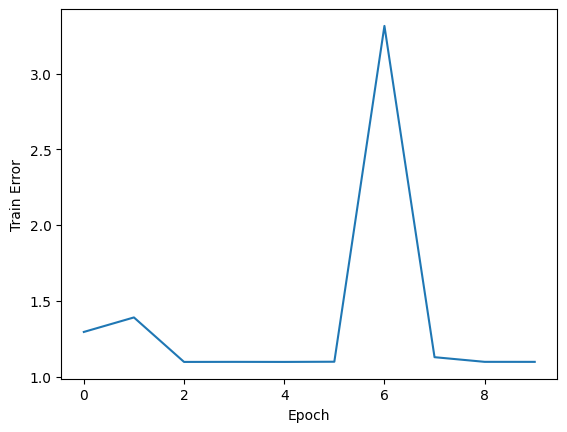

631/631 [==============================] - 1s 2ms/step
Mean Absolute Error: 0.8250446251487505


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)

plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mae = mean_absolute_error(y_true, y_hat)
print("Mean Absolute Error:", mae)


In [15]:
y_true

93821    2.0
88824    4.5
15673    4.0
62333    3.0
80471    3.0
        ... 
8433     4.0
40701    5.0
45537    4.0
66989    3.0
37544    4.5
Name: rating, Length: 20168, dtype: float64

In [16]:
y_hat

array([[3.5],
       [3.5],
       [3.5],
       ...,
       [3.5],
       [3.5],
       [3.5]], dtype=float32)

# MLP

In [17]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization, Concatenate, Dot
from keras.optimizers import Adam

latent_dim = 10

# Define inputs
movie_input = Input(shape=[1], name='movie-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
movie_embedding_mlp = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mlp')(movie_input)
movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
movie_embedding_mf = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mf')(movie_input)
movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = Concatenate(name='concat')([movie_vec_mlp, user_vec_mlp])
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = Dot(axes=-1, name='pred-mf')([movie_vec_mf, user_vec_mf])
combine_mlp_mf = Concatenate(name='combine-mlp-mf')([pred_mf, pred_mlp])

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, movie_input], result)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')

# Since we're not using visualization, there's no need for the following lines:
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [18]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie-input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user-input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie-embedding-mlp (Embed  (None, 1, 10)                97250     ['movie-input[0][0]']         
 ding)                                                                                            
                                                                                                  
 user-embedding-mlp (Embedd  (None, 1, 10)                6110      ['user-input[0][0]']    

Epoch 1/10
2521/2521 [==============================] - 15s 5ms/step - loss: 0.7780
Epoch 2/10
2521/2521 [==============================] - 12s 5ms/step - loss: 0.6394
Epoch 3/10
2521/2521 [==============================] - 12s 5ms/step - loss: 0.5677
Epoch 4/10
2521/2521 [==============================] - 12s 5ms/step - loss: 0.5243
Epoch 5/10
2521/2521 [==============================] - 12s 5ms/step - loss: 0.4942
Epoch 6/10
2521/2521 [==============================] - 12s 5ms/step - loss: 0.4744
Epoch 7/10
2521/2521 [==============================] - 12s 5ms/step - loss: 0.4589
Epoch 8/10
2521/2521 [==============================] - 12s 5ms/step - loss: 0.4449
Epoch 9/10
2521/2521 [==============================] - 12s 5ms/step - loss: 0.4340
Epoch 10/10
2521/2521 [==============================] - 12s 5ms/step - loss: 0.4280


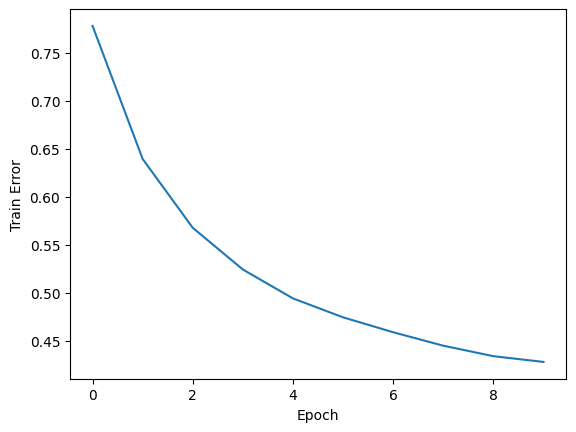

631/631 [==============================] - 2s 2ms/step


0.7150788386202743

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Train the model
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)

# Plot training loss
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

# Predict and calculate mean absolute error
y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)


In [20]:
y_hat

array([[3.04],
       [4.18],
       [3.67],
       ...,
       [3.12],
       [3.25],
       [3.76]], dtype=float32)